# "The effect of model resolution on air-sea CO$_{2}$ equilibration timescales "
## Code for Figure 2 and 3
Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

In [13]:
# Importing relevant modules.
import numpy as np
import xarray as xr
import time
import cftime
import datetime as dt
from datetime import timedelta
from datetime import datetime
import os
import re
from glob import glob
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
from collections import defaultdict

# Declare and load global variables

In [11]:
# Manually assign working directory
local_dir = '/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files'
main_directory = f'{local_dir}/Analysis_&_result'

area_regrid_1deg = np.load('/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/DIC_Cubic/area_regrid_1deg.npy')
grid010 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')

def get_res_value(char):
    if char.startswith("1deg_j"):
        return '1'
    elif char.startswith("01deg_"):
        return '0.1'
    elif char.startswith("025deg"):
        return '0.25'
    else:
        return None
        

Normalized_180x360x50_files_ADIC = {'group_1': {}, 'group_2': {}, 'group_3': {},'group_4': {}}
for Normalized_180x360x50_files,tar_str in zip([Normalized_180x360x50_files_ADIC],['Normalizatied_180x360x50_DIC_deficit_']):
    print('\n',tar_str,'\n')
    Results_3Res_All_sites_Ver_Prof_Res_Comp = {} 
    
    # Define a list of lab directories
    All_exp_dirs = [
        '1deg_jra55_iaf_spin_up_step_5400s_Group_1', '025deg_jra55_iaf_cycle_7_Group1', '01deg_jra55_iaf_group1_attempt_2',
        '1deg_jra55_iaf_spin_up_step_5400s_Group_2', '025deg_jra55_iaf_cycle_7_Group2', '01deg_jra55_iaf_group2',
        '1deg_jra55_iaf_spin_up_step_5400s_Group_3', '025deg_jra55_iaf_cycle_7_Group3', '01deg_jra55_iaf_group3',
        '1deg_jra55_iaf_spin_up_step_5400s_Group_4', '025deg_jra55_iaf_cycle_7_Group4', '01deg_jra55_iaf_Group4_3sites_adic_deficit_2004_07_01_07',
    ]
    
    exp_name =  {'02':'Eastern Australia','03':'Hawaii','04':  'Amazon', '05': 'Iceland','06':'Ross Sea','07':'Western Australia','08':'South China Sea','09':'Chile','10':'Brazil','11':'Eastern India','12':'Weddell Sea','13':'Eastern Antarctica', '16':'Tasmania','17':'Kuroshio Current','18':'West of Gibraltar','21':'Gulf Stream'}
    
    # 实验与站点对应关系
    exp_sites =      {'group_1':['04','07','12'],
                      'group_2':['05','16','17'],
                      'group_3':['06','08','18'],
                      'group_4':['03','13','21']}
    
    # 遍历所有实验目录
    for file_path in All_exp_dirs:
        # 从目录名获取分辨率值
        res = get_res_value(file_path[:6])
        
        # 确定组别
        if 'Group_1' in file_path or 'group1'  in file_path  or 'Group1' in file_path:
            group_key = 'group_1'
        elif 'Group_2' in file_path or 'group2' in file_path  or 'Group2'  in file_path:
            group_key = 'group_2'
        elif 'Group_3' in file_path or 'group3' in file_path  or 'Group3'  in file_path:
            group_key = 'group_3'
        elif 'Group_4' in file_path or 'group4' in file_path  or 'Group4'  in file_path:
            group_key = 'group_4'
        else:
            continue  # 如果没有匹配到任何已知组别，跳过这个文件路径
    
        # 获取当前实验目录的完整路径（假设你的实验目录在当前工作目录下的main_directory中）
        full_path = os.path.join(os.getcwd(), main_directory+'/'+file_path)
        print(full_path)

        # 搜索包含特定模式的文件
        for file in os.listdir(full_path):
            if tar_str in file:
                # 检查分辨率键值是否存在于字典中，如果不存在则创建
                if res not in Normalized_180x360x50_files[group_key]:
                    Normalized_180x360x50_files[group_key][res] = []
                
                # 添加文件路径到相应的分辨率键下
                Normalized_180x360x50_files[group_key][res].append(os.path.join(full_path, file))


 Normalizatied_180x360x50_DIC_deficit_ 

/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/1deg_jra55_iaf_spin_up_step_5400s_Group_1
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/025deg_jra55_iaf_cycle_7_Group1
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/01deg_jra55_iaf_group1_attempt_2
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/1deg_jra55_iaf_spin_up_step_5400s_Group_2
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/025deg_jra55_iaf_cycle_7_Group2
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/01deg_jra55_iaf_group2
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/1deg_jra55_iaf_spin_up_step_5400s_Group_3
/g/data/gv90/yx9454/Air-sea_CO2_equilibration_timescales_upload_files/Analysis_&_result/025deg_j

In [8]:
# Prepare a dictionary to store results and use defaultdict to avoid manual checking and situations
# where the create key is not present

all_times_ADIC        = []
organized_files_ADIC  = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for all_times,Normalized_180x360x50_files,organized_files in zip([all_times_ADIC],
                                                 [Normalized_180x360x50_files_ADIC],
                                                              [organized_files_ADIC]):
    for group, res_dict in Normalized_180x360x50_files.items():
        for res, files in res_dict.items():
            for file_path in files:
                file_name = os.path.basename(file_path)
                if 'PACO2' in file_name:
                    # Extract date information, such as '2006_01'
                    date_part = file_name.split('_')[4:6]  # ['2006', '01']
                    date_part[1]=date_part[1][:-4]
                    if len(date_part[1])==1:               # if like 2006_1, change to 2006_01
                        
                        date_part[1] = '0'+date_part[1]
                    date_key = '_'.join(date_part)  # '2006_01'
                
                if 'DIC' in file_name:
                    # Extract date information, such as '2006_01'
                    date_part = file_name.split('_')[4:6]  # ['2006', '01']
                    if len(date_part[1])==1:               # if like 2006_1, change to 2006_01
                        date_part[1] = '0'+date_part[1]
                    date_key = '_'.join(date_part)  # '2006_01'
                    if 'Restart' in file_name:
                        #date_part = file_name.split('_')[5:7]  # ['2006', '01']
                        #date_key = '_'.join(date_part)  # '2006_01'
                        continue        
                # Organizing Data
                organized_files[group][date_key][res].append(file_path)
    all_times[:] = sorted(set(time_key for group in organized_files.values() for time_key in group.keys()))

### Build region mask for all sites

In [10]:
Site_mask_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/DIC_Cubic/'

group_site = {'4':'group_1','7':'group_1','12':'group_1',
              '5':'group_2','16':'group_2','17':'group_2',
              '6':'group_3','8':'group_3','18':'group_3',
              '3':'group_4','13':'group_4','21':'group_4',}

#exp_hemi =  {'02':'S','03':'N','04':  'S', '05': 'N','06':'S','07':'S','08':'N','09':'S','10':'S','11':'N','12':'S','13':'S', '16':'S','17':'N','18':'N','21':'N'}
exp_hemi =  {'2':'S','3':'N','4':  'S', '5': 'N','6':'S','7':'S','8':'N','9':'S','10':'S','11':'N','12':'S','13':'S', '16':'S','17':'N','18':'N','21':'N'}

visualization_range = {'lon_min':{'2':'S','3':0,'4':  -100, '5': -100,'6':-180,'7':-25,'8':30,'9':'S','10':'S','11':'N','12':-180,'13':-180, '16':-180,'17':-255,'18':-100,'21':-100},
                       'lon_max':{'2':'S','3':290,'4':  30, '5': 90,'6':180,'7':180,'8':290,'9':'S','10':'S','11':'N','12':180,'13':180, '16':180,'17':-75,'18':60,'21':100},
                       'lat_min':{'2':'S','3':-45,'4':  -30, '5': 30,'6':-80,'7':-60,'8':-40,'9':'S','10':'S','11':'N','12':-80,'13':-80, '16':-70,'17':0,'18':-10,'21':-15},
                       'lat_max':{'2':'S','3':70,'4':  90, '5': 90,'6':15,'7':30,'8':90,'9':'S','10':'S','11':'N','12':-30,'13':-10, '16':0,'17':66,'18':90,'21':90}}

# Assign lat-lon region box
######## Range: -90 - 90
lat_min   = {'2': -29, '3': 17, '4': -7.5, '5': 58, '6': -75, '7': -33, '8': 10, '9': -50, '10': -25, '11': 12.5, '12': -75, '13': -75, '16': -45, '17': 35, '18': 33, '21': 30}
lat_max   = {'2': -24, '3': 22, '4': 0, '5': 65, '6': -70, '7': -26, '8': 15, '9': -40, '10': -20, '11': 17.5, '12': -70, '13': -65, '16': -40, '17': 40, '18': 39, '21': 35}
######## Range -280 - 80
lon_min   = {'2': 151-360, '3': -158, '4': -40, '5': -22.5, '6': -180, '7': 111-360, '8': 112.5-360, '9': -77.5, '10': -49, '11': 70, '12': -50, '13': 65, '16': 143-360, '17': 140.5-360, '18': -11, '21': -82}
lon_max   = {'2': 157-360, '3': -153, '4': -35, '5': -17, '6': -165, '7': 117-360, '8': 117.5-360, '9': -70, '10': -38, '11': 77.5, '12': -35, '13': 79.9, '16': 150-360, '17': 145.5-360, '18': -6, '21': -75}



site_color_old = {'Iceland':'b','Ross Sea':'royalblue','Weddell Sea':'deepskyblue','Eastern Antarctica':'lightskyblue',
              'Kuroshio Current':'g','Gulf Stream':'limegreen',
              'Western Australia':'brown','Tasmania':'orange','West of Gibraltar':'gold',
              'Hawaii':'m','Amazon':'lightcoral','South China Sea':'r'}
site_color = {'Iceland':'b','Ross Sea':'royalblue','Weddell Sea':'deepskyblue','Eastern Antarctica':'lightskyblue',
              'Kuroshio Current':'g','Gulf Stream':'limegreen',
              'Western Australia':'gold','Tasmania':'orange','West of Gibraltar':'goldenrod',
              'Hawaii':'orangered','Amazon':'crimson','South China Sea':'red'}

exp_name =  {'02':'Eastern Australia','03':'Hawaii','04':  'Amazon', '05': 'Iceland','06':'Ross Sea','07':'Western Australia','08':'South China Sea','09':'Chile','10':'Brazil','11':'Eastern India','12':'Weddell Sea','13':'Eastern Antarctica', '16':'Tasmania','17':'Kuroshio Current','18':'West of Gibraltar','21':'Gulf Stream'}

npz_file = np.load(organized_files['group_1']['2004_01']['1'][0])
lon_xy,lat_xy  = np.meshgrid(npz_file['longitude'],npz_file['latitude'])

In [12]:
# Use the existing two-dimensional latitude and longitude array
geolon_t = grid010.geolon_t  
geolat_t = grid010.geolat_t  

station_map = np.full(geolon_t.shape, np.nan)

for station_id, lat_min_val in lat_min.items():
    lat_max_val = lat_max[station_id]
    lon_min_val = lon_min[station_id]
    lon_max_val = lon_max[station_id]
    mask = (geolon_t >= lon_min_val) & (geolon_t <= lon_max_val) & (geolat_t >= lat_min_val) & (geolat_t <= lat_max_val)
    
    station_map[mask] = int(station_id)

ocean_mask = grid010.depth_t>0
station_map[~ocean_mask]=np.nan

# Figure 2 maps

4 1 2005_01
contourf done
04
7 1 2005_01
contourf done
07
12 1 2005_01
contourf done
12
5 1 2005_07
contourf done
05
16 1 2005_01
contourf done
16
17 1 2005_07
contourf done
17
6 1 2005_01
contourf done
06
8 1 2005_07
contourf done
08
18 1 2005_07
contourf done
18
3 1 2005_07
contourf done
03
13 1 2005_01
contourf done
13
21 1 2005_07
contourf done
21


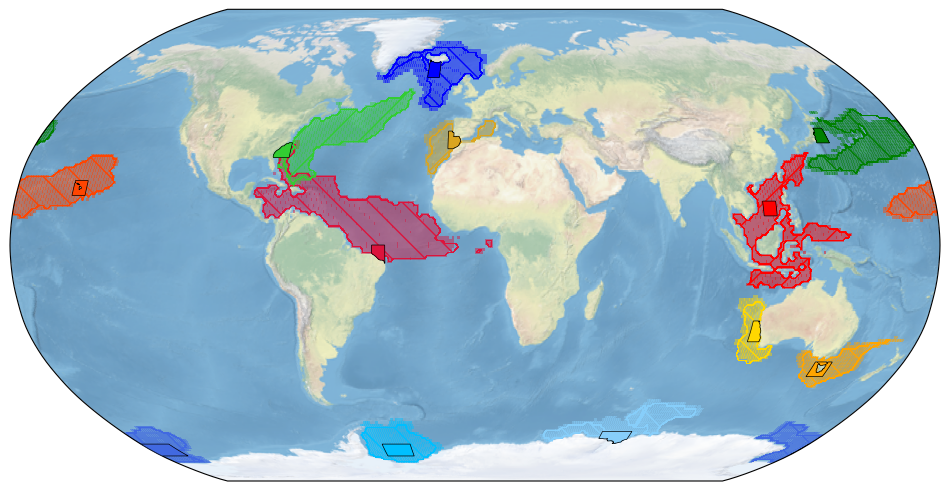

4 1 2007_01
contourf done
04
7 1 2007_01
contourf done
07
12 1 2007_01
contourf done
12
5 1 2007_07
contourf done
05
16 1 2007_01
contourf done
16
17 1 2007_07
contourf done
17
6 1 2007_01
contourf done
06
8 1 2007_07
contourf done
08
18 1 2007_07
contourf done
18
3 1 2007_07
contourf done
03
13 1 2007_01
contourf done
13
21 1 2007_07
contourf done
21


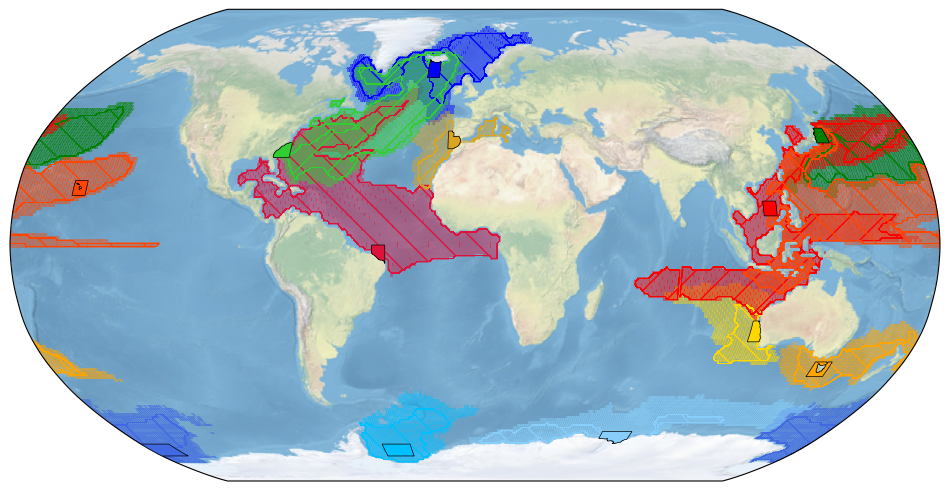

4 1 2009_01
contourf done
04
7 1 2009_01
contourf done
07
12 1 2009_01
contourf done
12
5 1 2009_07
contourf done
05
16 1 2009_01
contourf done
16
17 1 2009_07
contourf done
17
6 1 2009_01
contourf done
06
8 1 2009_07
contourf done
08
18 1 2009_07
contourf done
18
3 1 2009_07
contourf done
03
13 1 2009_01
contourf done
13
21 1 2009_07
contourf done
21


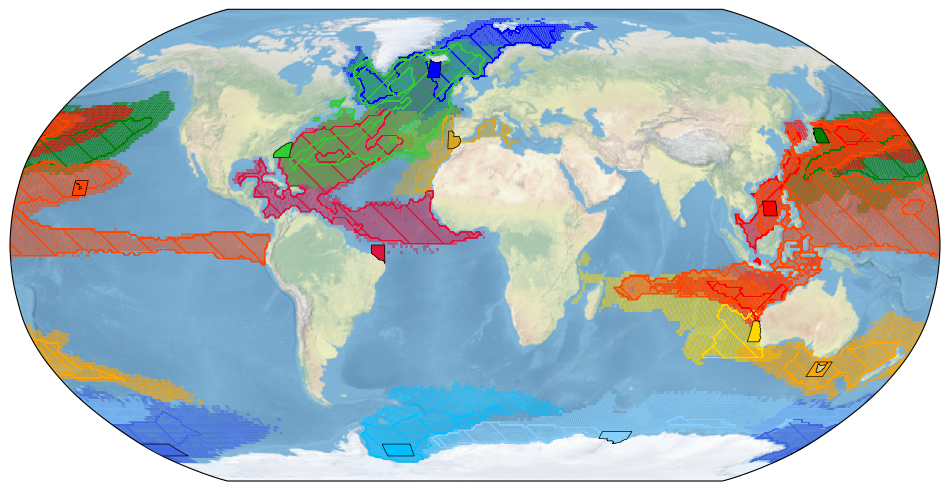

4 1 2014_01
contourf done
04
7 1 2014_01
contourf done
07
12 1 2014_01
contourf done
12
5 1 2014_07
contourf done
05
16 1 2014_01
contourf done
16
17 1 2014_07
contourf done
17
6 1 2014_01
contourf done
06
8 1 2014_07
contourf done
08
18 1 2014_07
contourf done
18
3 1 2014_07
contourf done
03
13 1 2014_01
contourf done
13
21 1 2014_07
contourf done
21


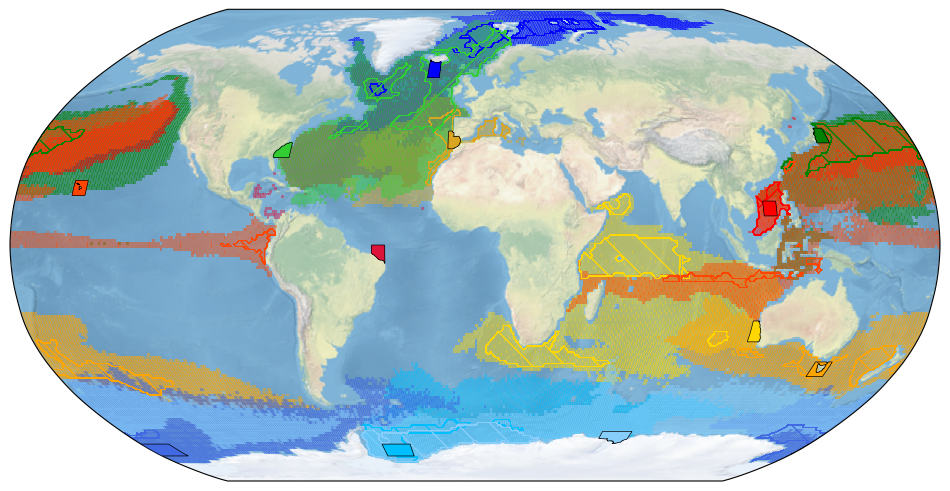

4 0.25 2005_01
contourf done
04
7 0.25 2005_01
contourf done
07
12 0.25 2005_01
contourf done
12
5 0.25 2005_07
contourf done
05
16 0.25 2005_01
contourf done
16
17 0.25 2005_07
contourf done
17
6 0.25 2005_01
contourf done
06
8 0.25 2005_07
contourf done
08
18 0.25 2005_07
contourf done
18
3 0.25 2005_07
contourf done
03
13 0.25 2005_01
contourf done
13
21 0.25 2005_07
contourf done
21


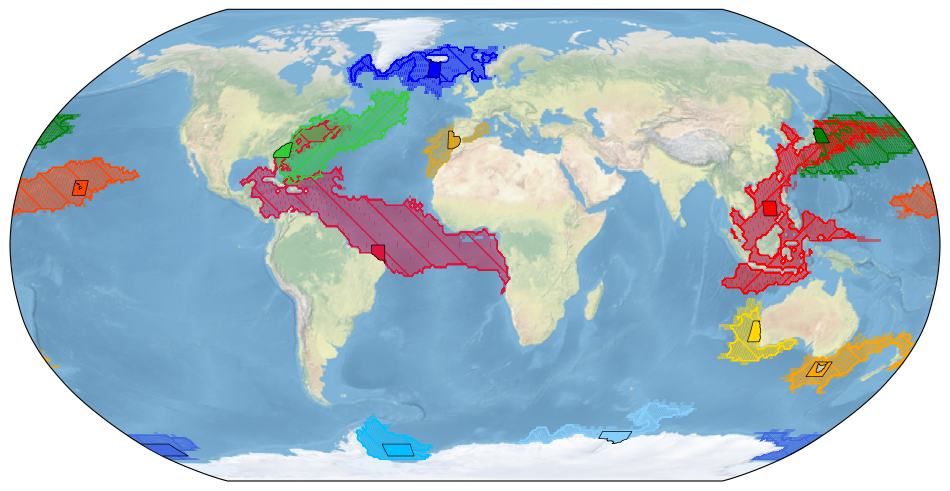

4 0.25 2007_01
contourf done
04
7 0.25 2007_01
contourf done
07
12 0.25 2007_01
contourf done
12
5 0.25 2007_07
contourf done
05
16 0.25 2007_01
contourf done
16
17 0.25 2007_07
contourf done
17
6 0.25 2007_01
contourf done
06
8 0.25 2007_07
contourf done
08
18 0.25 2007_07
contourf done
18
3 0.25 2007_07
contourf done
03
13 0.25 2007_01
contourf done
13
21 0.25 2007_07
contourf done
21


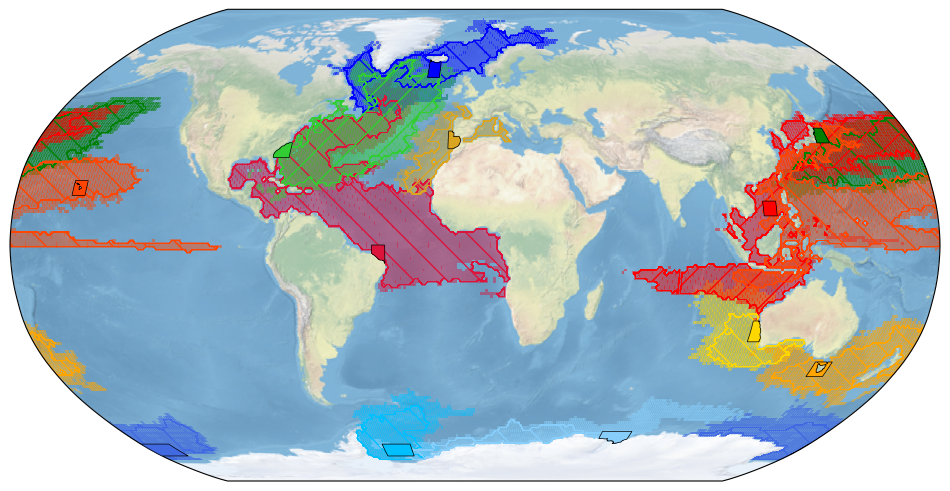

4 0.25 2008_12
contourf done
04
7 0.25 2008_12
contourf done
07
12 0.25 2008_12
contourf done
12
5 0.25 2009_07
contourf done
05
16 0.25 2009_01
contourf done
16
17 0.25 2009_07
contourf done
17
6 0.25 2009_01
contourf done
06
8 0.25 2009_07
contourf done
08
18 0.25 2009_07
contourf done
18
3 0.25 2009_07
contourf done
03
13 0.25 2009_01
contourf done
13
21 0.25 2009_07
contourf done
21


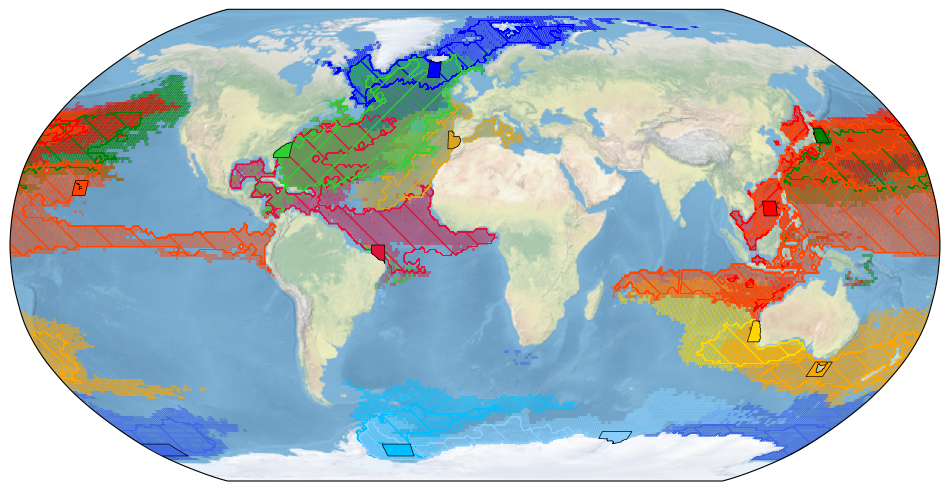

4 0.25 2014_01
ADIC File not found, skipping...
7 0.25 2014_01
ADIC File not found, skipping...
12 0.25 2014_01
ADIC File not found, skipping...
5 0.25 2014_07
ADIC File not found, skipping...
16 0.25 2014_01
ADIC File not found, skipping...
17 0.25 2014_07
ADIC File not found, skipping...
6 0.25 2014_01
ADIC File not found, skipping...
8 0.25 2014_07
ADIC File not found, skipping...
18 0.25 2014_07
ADIC File not found, skipping...
3 0.25 2014_07
ADIC File not found, skipping...
13 0.25 2014_01
ADIC File not found, skipping...
21 0.25 2014_07
ADIC File not found, skipping...


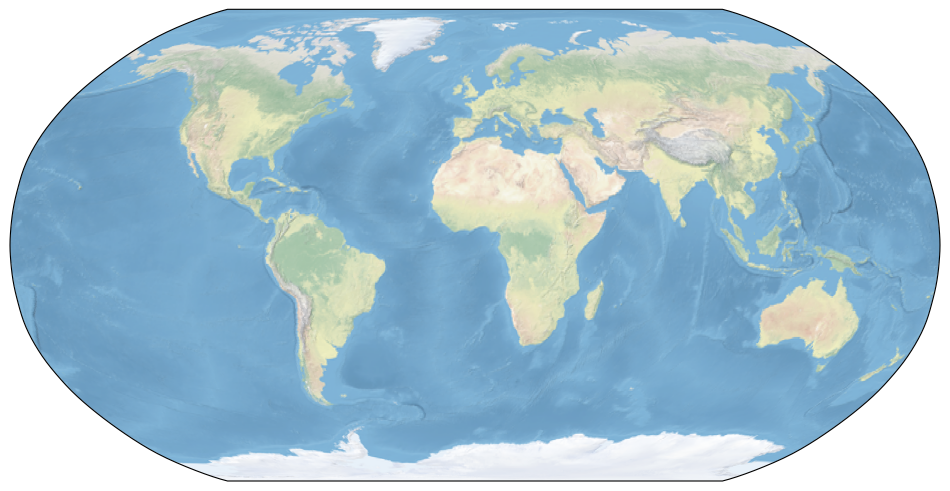

4 0.1 2005_01
contourf done
04
7 0.1 2005_01
contourf done
07
12 0.1 2005_01
contourf done
12
5 0.1 2005_07
contourf done
05
16 0.1 2005_01
contourf done
16
17 0.1 2005_07
contourf done
17
6 0.1 2005_01
contourf done
06
8 0.1 2005_07
contourf done
08
18 0.1 2005_07
contourf done
18
3 0.1 2005_07
contourf done
03
13 0.1 2005_01
contourf done
13
21 0.1 2005_07
contourf done
21


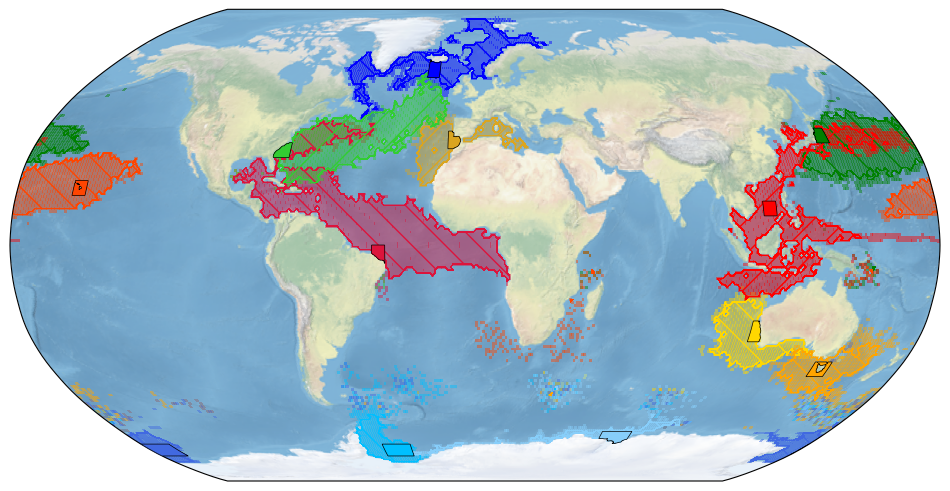

4 0.1 2007_01
contourf done
04
7 0.1 2007_01
contourf done
07
12 0.1 2007_01
contourf done
12
5 0.1 2007_07
contourf done
05
16 0.1 2007_01
contourf done
16
17 0.1 2007_07
contourf done
17
6 0.1 2007_01
contourf done
06
8 0.1 2007_07
contourf done
08
18 0.1 2007_07
contourf done
18
3 0.1 2007_07
contourf done
03
13 0.1 2007_01
contourf done
13
21 0.1 2007_07
contourf done
21


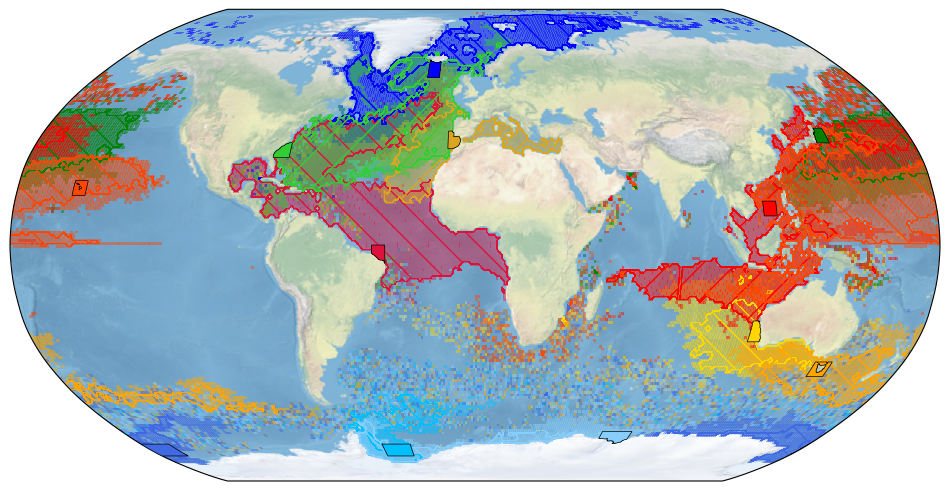

4 0.1 2009_01
ADIC File not found, skipping...
7 0.1 2009_01
ADIC File not found, skipping...
12 0.1 2009_01
ADIC File not found, skipping...
5 0.1 2009_07
ADIC File not found, skipping...
16 0.1 2009_01
ADIC File not found, skipping...
17 0.1 2009_07
ADIC File not found, skipping...
6 0.1 2009_01
ADIC File not found, skipping...
8 0.1 2009_07
ADIC File not found, skipping...
18 0.1 2009_07
ADIC File not found, skipping...
3 0.1 2009_07
ADIC File not found, skipping...
13 0.1 2009_01
ADIC File not found, skipping...
21 0.1 2009_07
ADIC File not found, skipping...


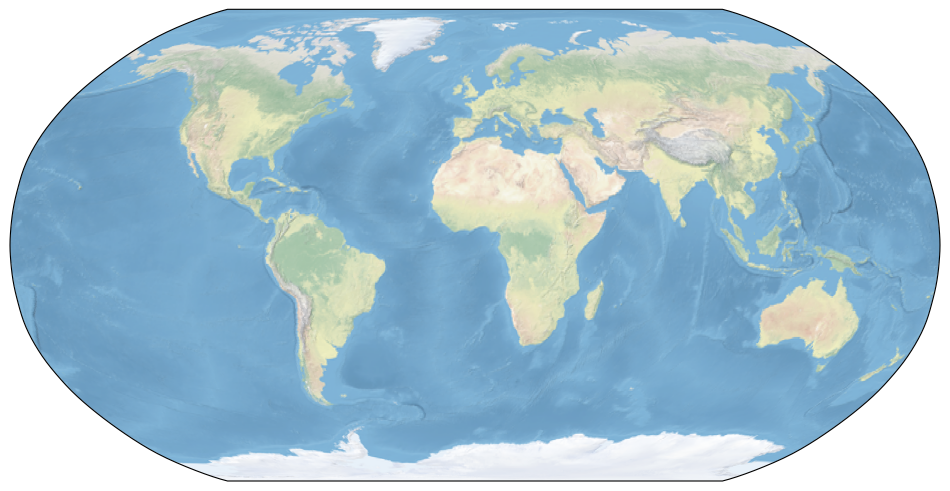

4 0.1 2014_01
ADIC File not found, skipping...
7 0.1 2014_01
ADIC File not found, skipping...
12 0.1 2014_01
ADIC File not found, skipping...
5 0.1 2014_07
ADIC File not found, skipping...
16 0.1 2014_01
ADIC File not found, skipping...
17 0.1 2014_07
ADIC File not found, skipping...
6 0.1 2014_01
ADIC File not found, skipping...
8 0.1 2014_07
ADIC File not found, skipping...
18 0.1 2014_07
ADIC File not found, skipping...
3 0.1 2014_07
ADIC File not found, skipping...
13 0.1 2014_01
ADIC File not found, skipping...
21 0.1 2014_07
ADIC File not found, skipping...


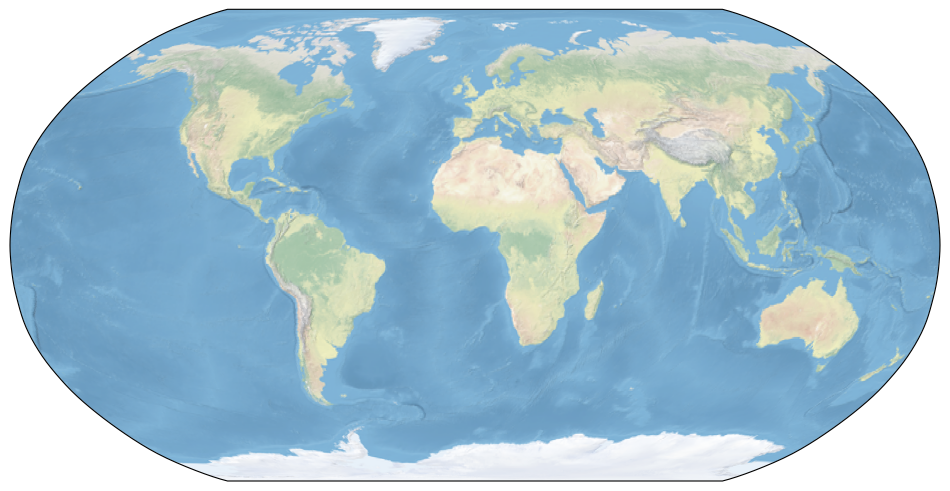

In [124]:
ADIC_thre  = 1e-1
ADIC_0_100_thre = 1e-1


save_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/Main_Fig/'

resolutions = ['1','0.25','0.1']     # 1 0.25 0.1
dates_N = ['2005_07','2007_07','2009_07','2014_07',]
dates_S = ['2005_01','2007_01','2009_01','2014_01',]
# which is 
after_years_s = ['1','3','5','10']

save_flag = True
for  resolution in resolutions:   #
    for date_N,date_S,after_years in zip(dates_N,dates_S,after_years_s):
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.Robinson())
        # Add a color continental map
        ax.stock_img()

        for site in ['4','7','12','5','16','17','6','8','18','3','13','21']: #['16','6','8']:#
            if len(site)==1:
                station_id='0'+site
            else:
                station_id = site
                
            group = group_site[site]
            hemi = exp_hemi[site]
            if hemi == 'S':
                date = date_S
                if resolution=='0.25' and after_years=='5' and (site in ['4','7','12']):
                    date = '2008_12'
            
            elif hemi == 'N':
                date = date_N
    
            mask = np.load(Site_mask_dir+'Site_mask_'+str(site)+'_180_360.npy')

            
            print(site,resolution,date)
            try:
                npz_file_ADIC = np.load(organized_files_ADIC[group][date][resolution][0])
                deficit_ADIC = npz_file_ADIC['data']
            except IndexError:
                print(f"ADIC File not found, skipping...")
                continue  # Skip the current iteration and move to the next date
            deficit_ADIC[:,~mask]         = np.nan
            
            tar_ADIC = np.nansum(deficit_ADIC,axis=0)/area_regrid_1deg
            tar_ADIC[tar_ADIC<=ADIC_thre] = np.nan
            tar_ADIC[tar_ADIC>ADIC_thre]  = 1

            tar_ADIC_0_100 = np.nansum(deficit_ADIC[:14],axis=0)/area_regrid_1deg
            tar_ADIC_0_100[tar_ADIC_0_100<=ADIC_0_100_thre] = np.nan
            tar_ADIC_0_100[tar_ADIC_0_100>ADIC_0_100_thre]  = 1


            single_color_cmap_ADIC  = ListedColormap([site_color[exp_name[station_id]]])
            
            mesh_ADIC  = ax.pcolormesh(lon_xy,lat_xy, tar_ADIC, transform=ccrs.PlateCarree(), zorder=1,
                                       cmap=single_color_cmap_ADIC,alpha=0.45)
            
            # Overlay fill style, applied only to non-zero regions
            # Draw contour lines for tar_PACO2, ensuring that the transform parameter matches the geographical range
            try:
                hatch_styles = ['\\', 'xx'] if site not in ['8', '18', '21'] else ['/', 'xx']
                cs = ax.contourf(
                    lon_xy + 360, lat_xy, tar_ADIC_0_100,
                    colors='none', levels=[0.9, 1.1],
                    hatches=hatch_styles, zorder=2,
                    transform=ccrs.PlateCarree(),
                    linewidths=0.3
                )
                cs.set_edgecolor(site_color[exp_name[station_id]])
                cs.set_linewidths(0.3)
                print('contourf done')
            except TypeError as e:
                print("Error occurred during contour plotting:", e)

            print(station_id)
            site_name = exp_name[station_id]
            color = site_color.get(site_name, 'gray')  # Use the site name to get the color from site_color
            
            tar = np.copy(station_map)
            tar[tar!=int(station_id)]=np.nan
            # Use contourf to draw fill contours, specifying a single color
            contour_filled = ax.contourf(grid010.geolon_t, grid010.geolat_t, tar, 
                                         transform=ccrs.PlateCarree(), levels=[0, 100], 
                                         colors=[color], zorder=10)
            
            # Use contour to draw the edge, specifying the color and line width of the edge
            tar[np.isnan(tar)]=0
            contour_edges = ax.contour(grid010.geolon_t, grid010.geolat_t, tar, 
                                       transform=ccrs.PlateCarree(), levels=[-1,0, 100], 
                                       colors='black', linewidths=0.5, zorder=11)

        if save_flag:
            plt.savefig(f'{save_dir}0-100mDIC_to_FullDepthADIC_comparsion_Res[{resolution}]_after_{after_years}_years.png', bbox_inches='tight', pad_inches=0, dpi=300)
        plt.show()


In [65]:
ADIC_thre  = 1e-1
PACO2_thre = 1e-3

save_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/Main_Fig/'

resolutions = ['1','0.25','0.1']     # 1 0.25 0.1
dates_N = ['2005_07','2007_07','2009_07','2014_07']   #['2005_07','2007_07','2009_07','2014_07',]
dates_S = ['2005_01','2007_01','2009_01','2014_01']   #['2005_01','2007_01','2009_01','2014_01',]
# which is 
after_years_s = ['1','3','5','10']

ADIC_Full_depth_s      = {'1': {}, '0.25': {}, '0.1': {}}
ADIC_0_100m_s          = {'1': {}, '0.25': {}, '0.1': {}}
ADIC_Full_depth_map_s  = {'1': {}, '0.25': {}, '0.1': {}}
ADIC_0_100m_map_s      = {'1': {}, '0.25': {}, '0.1': {}}

save_flag = True

for  resolution in resolutions:   #
    i = 0
    for date_N,date_S in zip(dates_N,dates_S):
        after_years = after_years_s[i]
        for site in ['4','7','12','5','16','17','6','8','18','3','13','21']: 
            if len(site)==1:
                station_id='0'+site
            else:
                station_id = site
                
            group = group_site[site]
            hemi = exp_hemi[site]
            if hemi == 'S':
                date = date_S
                if resolution=='0.25' and date=='2009_01' and (site in ['4','7','12']):
                    date = '2008_12'
            
            elif hemi == 'N':
                date = date_N
    
            mask = np.load(Site_mask_dir+'Site_mask_'+str(site)+'_180_360.npy')

            
            print('site',site,'resolution',resolution,'date',date,'after_years',after_years,)
            try:
                npz_file_ADIC = np.load(organized_files_ADIC[group][date][resolution][0])['data']
                npz_file_ADIC[:, ~mask]         = np.nan
                ADIC_Full_depth = np.nansum(npz_file_ADIC)
                ADIC_0_100m     = np.nansum(npz_file_ADIC[:14])
                ADIC_Full_depth_map = np.nansum(npz_file_ADIC,axis=0)
                ADIC_0_100m_map     = np.nansum(npz_file_ADIC[:14],axis=0)
            except IndexError:
                print(f"ADIC File not found, skipping...")
                continue  # Skip the current iteration and move to the next date

            if site not in ADIC_Full_depth_s[resolution]:
                ADIC_Full_depth_s[resolution][site] = [ADIC_Full_depth]
            else:
                ADIC_Full_depth_s[resolution][site].append(ADIC_Full_depth)
            
            if site not in ADIC_0_100m_s[resolution]:
                ADIC_0_100m_s[resolution][site] = [ADIC_0_100m]
            else:
                ADIC_0_100m_s[resolution][site].append(ADIC_0_100m)
                
        i+=1

site 4 resolution 1 date 2005_01 after_years 1
site 7 resolution 1 date 2005_01 after_years 1
site 12 resolution 1 date 2005_01 after_years 1
site 5 resolution 1 date 2005_07 after_years 1
site 16 resolution 1 date 2005_01 after_years 1
site 17 resolution 1 date 2005_07 after_years 1
site 6 resolution 1 date 2005_01 after_years 1
site 8 resolution 1 date 2005_07 after_years 1
site 18 resolution 1 date 2005_07 after_years 1
site 3 resolution 1 date 2005_07 after_years 1
site 13 resolution 1 date 2005_01 after_years 1
site 21 resolution 1 date 2005_07 after_years 1
site 4 resolution 1 date 2007_01 after_years 3
site 7 resolution 1 date 2007_01 after_years 3
site 12 resolution 1 date 2007_01 after_years 3
site 5 resolution 1 date 2007_07 after_years 3
site 16 resolution 1 date 2007_01 after_years 3
site 17 resolution 1 date 2007_07 after_years 3
site 6 resolution 1 date 2007_01 after_years 3
site 8 resolution 1 date 2007_07 after_years 3
site 18 resolution 1 date 2007_07 after_years 3
sit

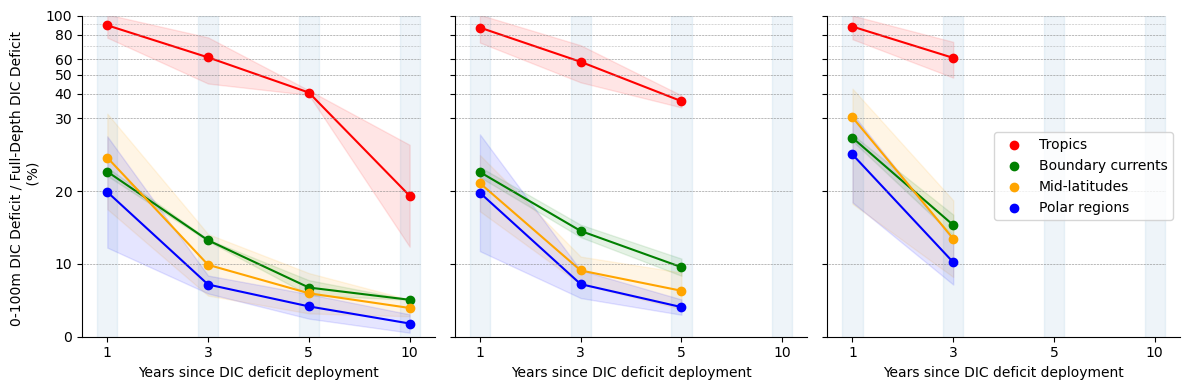

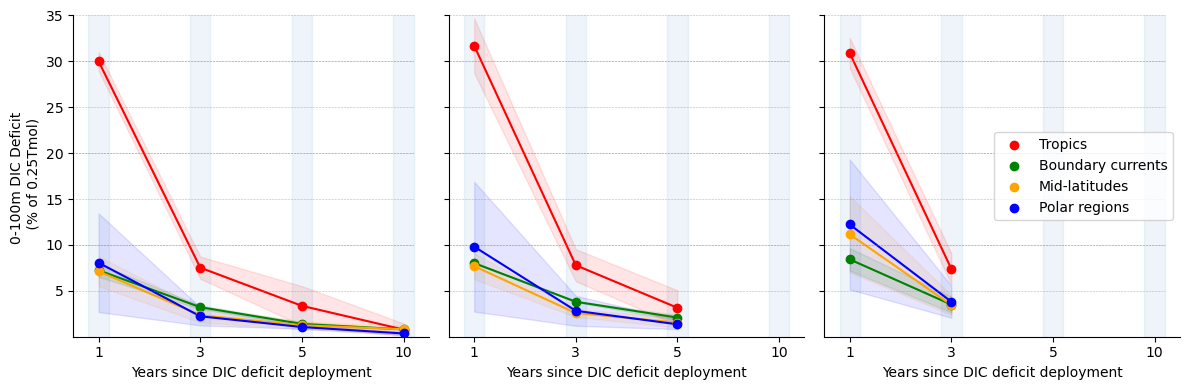

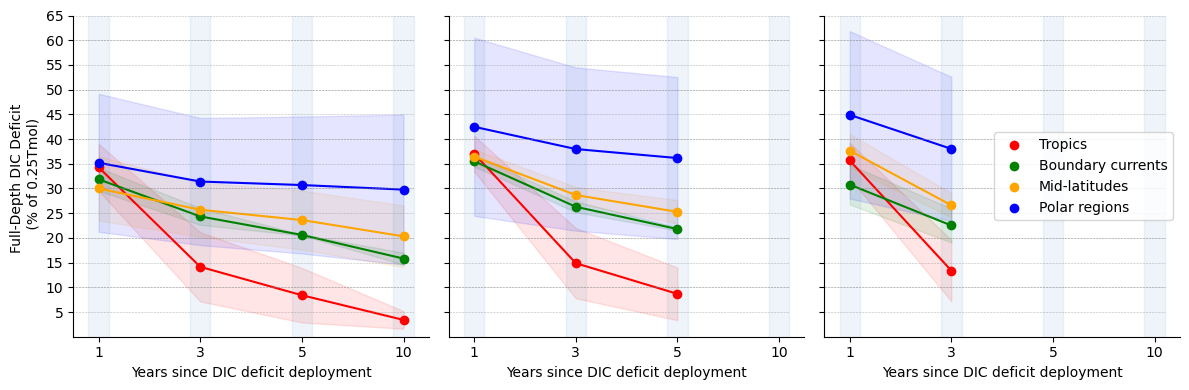

In [9]:
resolutions = ['1', '0.25', '0.1']
from matplotlib.ticker import ScalarFormatter
# Plotting Flag
Plot_12_Sites = False
Plot_4_Catrogries  = True


for keyword in ['100_vs_full','100','full']:
    # 创建1行3列子图
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # 使用for循环绘制子图
    for i, resolution in enumerate(resolutions):
        if Plot_12_Sites:
            for site in ['4','7','12','5','16','17','6','8','18','3','13','21']:
                if len(site)==1:
                    station_id='0'+site
                else:
                    station_id = site
                if keyword == '100_vs_full':
                    tar = 100*np.array([p / a for p, a in zip(ADIC_0_100m_s[resolution][site], ADIC_Full_depth_s[resolution][site])])
                elif keyword == '100':
                    tar = np.array(ADIC_0_100m_s[resolution][site])/1e6/1e15/0.25*100
                elif keyword == 'full':
                    tar = np.array(ADIC_Full_depth_s[resolution][site])/1e6/1e15/0.25*100
    
                tar[tar==0] = 1e-9
                axes[i].plot(tar,
                             c=site_color[exp_name[station_id]],zorder=1)
                axes[i].scatter(np.arange(len(tar)),tar,
                                c=site_color[exp_name[station_id]],label=exp_name[station_id],zorder=2)
        elif Plot_4_Catrogries:
            cate_colors = {'Tropics':'r','Boundary currents':'g','Mid-latitudes':'orange','Polar regions':'b'}
            for cate,sites_here in zip(['Tropics','Boundary currents','Mid-latitudes','Polar regions'],[['3','4','8'],['17','21'],['7','16','18'],['5','6','12','13']]):
                tar_set = []
                for site in sites_here:
                    if keyword == '100_vs_full':
                        tar = 100*np.array([p / a for p, a in zip(ADIC_0_100m_s[resolution][site], ADIC_Full_depth_s[resolution][site])])
                    elif keyword == '100':
                        tar = np.array(ADIC_0_100m_s[resolution][site])/1e15/0.25*100
                    elif keyword == 'full':
                        tar = np.array(ADIC_Full_depth_s[resolution][site])/1e15/0.25*100
                    tar_set.append(tar)
                tar_mean = np.mean(tar_set,axis=0)
                tar_mean[tar_mean==0] = 1e-9
                
                tar_std = np.std(tar_set,axis=0)
                
                axes[i].plot(tar_mean,
                             c=cate_colors[cate],zorder=1)
                axes[i].scatter(np.arange(len(tar_mean)),tar_mean,
                                c=cate_colors[cate],label=cate,zorder=2)
                axes[i].fill_between(np.arange(len(tar_mean)), tar_std +tar_mean , tar_mean - tar_std, alpha=0.1,zorder=0,color=cate_colors[cate])
            

        
        axes[i].set_xlabel('Years since DIC deficit deployment')
        
        
            
        if resolution =='0.1':
            if Plot_12_Sites:
                sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica','Kuroshio Current','Gulf Stream','Western Australia','Tasmania','West of Gibraltar','Hawaii','Amazon','South China Sea']
                # 获取当前的图例句柄和标签
                handles, labels = axes[i].get_legend_handles_labels()
                # Works when valid sites are less than 12
                sites_ordered_labels = [i for i in sites_ordered_labels  if i in labels]
                # 根据给定的标签顺序重排 handles 和 labels
                ordered_handles = [handles[labels.index(label)] for label in sites_ordered_labels]
                ordered_labels = [label for label in sites_ordered_labels]
                axes[i].legend(ordered_handles, ordered_labels, loc='right')
            elif Plot_4_Catrogries:
                axes[i].legend(loc='right')
        
        axes[i].set_xlim(-0.25,3.25)
        if keyword == '100_vs_full':
            axes[i].set_ylim(0,100)
            if resolution == '1':
                axes[i].set_ylabel('0-100m DIC Deficit / Full-Depth DIC Deficit \n (%)')
            axes[i].set_yscale('symlog', linthresh=30)
            yticks = [0,10,20,30,40,50,60,80,100]
            for y in yticks:
                axes[i].plot([-1,3.1],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)

        elif keyword == '100':
            axes[i].set_ylim(0,35)
            yticks = [5,10,15,20,25,30,35]
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)
            for y in yticks:
                axes[i].plot([-1,3.1],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            if resolution == '1':
                axes[i].set_ylabel('0-100m DIC Deficit \n (% of 0.25Tmol)')
        elif keyword == 'full':
            axes[i].set_ylim(0,65)
            yticks = [5,10,15,20,25,30,35,40,45,50,55,60,65]
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)
            for y in yticks:
                axes[i].plot([-1,3.1],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            if resolution == '1':
                axes[i].set_ylabel('Full-Depth DIC Deficit \n (% of 0.25Tmol)')

        
        for x_loc in np.arange(0,4):
            axes[i].fill_between([x_loc-0.1,x_loc+0.1], [-10,-10],[100,100], alpha=0.075,zorder=0,color='C0')
    
        for y in np.arange(100,130,10):
            axes[i].plot([-1,3.1],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.3)
        for y in np.arange(0,100,10):
            axes[i].plot([-1,3.1],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
    
        axes[i].spines['right'].set_visible(False) 
        axes[i].spines['top'].set_visible(False)
        if i !=0:
            axes[i].tick_params(axis='y',labelleft=False)
        # 手动设置 x 轴刻度和标签
        xticks = [0, 1, 2, 3]  # 位置
        xlabels = ['1', '3', '5', '10']  # 对应的字符标签
        axes[i].set_xticks(xticks)
        axes[i].set_xticklabels(xlabels)
            
    # 调整布局并显示
    plt.tight_layout()
    if Plot_12_Sites:
        plt.savefig(f'{save_dir}0-100mDIC_to_FullDepthADIC_TimeSeries_flag_{keyword}.png',dpi=300)
    elif Plot_4_Catrogries:
        plt.savefig(f'{save_dir}100mDIC_to_FullDepthADIC_TimeSeries_flag_{keyword}_Category_mean.png',dpi=300)
    plt.show()

## Figure 3 and Figure S3 panel a,b and c

In [17]:
# Plotting Flag
Plot_12_Sites = True       # Flag for plotting Figure S3
Plot_4_Catrogries  = False # Flag for plotting Figure 3

In [14]:
# Function to get the intersection of available months across all groups for each resolution
def get_global_months_intersection(data):
    resolution_months = defaultdict(set)
    for group, years_months in data.items():
        for year_month, res_files in years_months.items():
            for resolution, files in res_files.items():
                if files:  # If there are files for this resolution
                    resolution_months[resolution].add(year_month)
    
    # Calculate the global intersection of months for each resolution
    intersection_result = {
        resolution: sorted(months)  # Sort the months for consistency
        for resolution, months in resolution_months.items()
    }
    return intersection_result

def convert_to_fraction(months):
    def month_to_fraction(month_str):
        year, month = map(int, month_str.split('_'))
        fraction = (month) / 12  # Convert month to fraction
        return round(year + fraction, 4)  # Add year and fraction, round to 4 decimals
    
    return [month_to_fraction(month) for month in months]

available_months = get_global_months_intersection(organized_files_ADIC)

In [15]:
ADIC_thre  = 1e-1
PACO2_thre = 1e-3

save_dir = '/g/data/jk72/yx9454/PhD_Ch2/Analysis_&_result/Main_Fig/'

resolutions = ['1','0.25','0.1']     # 1 0.25 0.1
dates_N = np.array(available_months['1'])[np.array(available_months['1'])>='2004_07']
dates_S = np.array(available_months['1'])[np.array(available_months['1'])>='2004_01']
# Convert the array
after_years_s = np.array(convert_to_fraction(dates_S)) - 2004

ADIC_Full_depth_s  = {'1': {}, '0.25': {}, '0.1': {}}
ADIC_0_100m_s      = {'1': {}, '0.25': {}, '0.1': {}}

save_flag = True

for  resolution in resolutions:   #
    i = 0
    for date_N,date_S in zip(dates_N,dates_S):
        after_years = after_years_s[i]
        for site in ['4','7','12','5','16','17','6','8','18','3','13','21']: 
            if len(site)==1:
                station_id='0'+site
            else:
                station_id = site
                
            group = group_site[site]
            hemi = exp_hemi[site]
            if hemi == 'S':
                date = date_S
            
            elif hemi == 'N':
                date = date_N
    
            mask = np.load(Site_mask_dir+'Site_mask_'+str(site)+'_180_360.npy')

            try:
                npz_file_ADIC = np.load(organized_files_ADIC[group][date][resolution][0])['data']
                npz_file_ADIC[:, ~mask]         = np.nan
                ADIC_Full_depth = np.nansum(npz_file_ADIC)
                ADIC_0_100m     = np.nansum(npz_file_ADIC[:14])
            except IndexError:
                print(f"ADIC File not found, skipping...")
                continue  # Skip the current iteration and move to the next date

            if site not in ADIC_Full_depth_s[resolution]:
                ADIC_Full_depth_s[resolution][site] = [ADIC_Full_depth]
            else:
                ADIC_Full_depth_s[resolution][site].append(ADIC_Full_depth)
            
            if site not in ADIC_0_100m_s[resolution]:
                ADIC_0_100m_s[resolution][site] = [ADIC_0_100m]
            else:
                ADIC_0_100m_s[resolution][site].append(ADIC_0_100m)
                
        i+=1

ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File not found, skipping...
ADIC File 

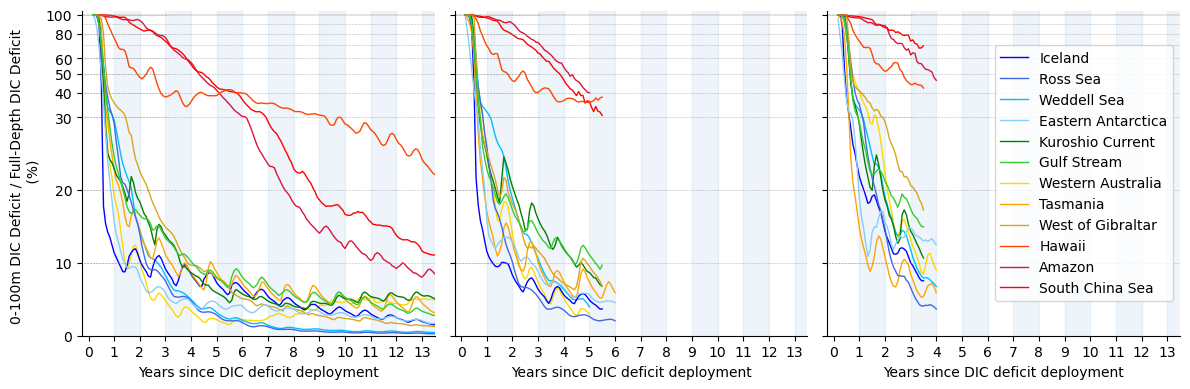

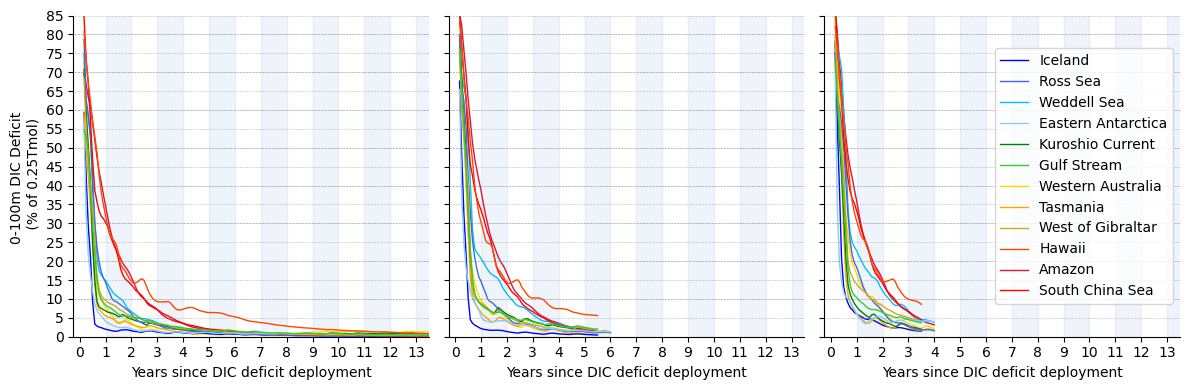

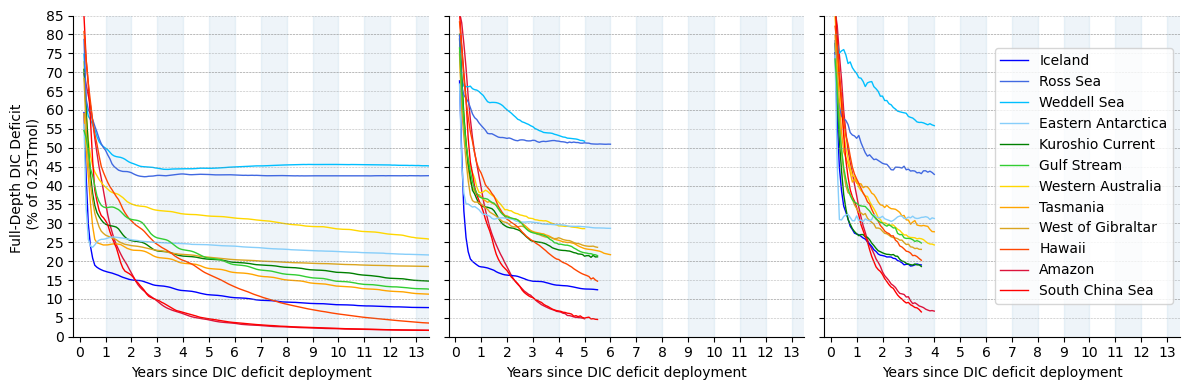

In [16]:
resolutions = ['1', '0.25', '0.1']
from matplotlib.ticker import ScalarFormatter

for keyword in ['100_vs_full','100','full']:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    for i, resolution in enumerate(resolutions):
        if Plot_12_Sites:
            for site in ['4','7','12','5','16','17','6','8','18','3','13','21']:
                if len(site)==1:
                    station_id='0'+site
                else:
                    station_id = site
                if keyword == '100_vs_full':
                    tar = 100*np.array([p / a for p, a in zip(ADIC_0_100m_s[resolution][site], ADIC_Full_depth_s[resolution][site])])
                elif keyword == '100':
                    tar = np.array(ADIC_0_100m_s[resolution][site])/1e15/0.25*100
                elif keyword == 'full':
                    tar = np.array(ADIC_Full_depth_s[resolution][site])/1e15/0.25*100
    
                tar[tar==0] = 1e-9
                axes[i].plot(after_years_s[1:len(tar)], tar[1:],
                             c=site_color[exp_name[station_id]],zorder=1,label=exp_name[station_id],linewidth=1)

        elif Plot_4_Catrogries:
            cate_colors = {'Tropics':'r','Boundary currents':'g','Mid-latitudes':'orange','Polar regions':'b'}
            for cate,sites_here in zip(['Tropics','Boundary currents','Mid-latitudes','Polar regions'],[['3','4','8'],['17','21'],['7','16','18'],['5','6','12','13']]):
                tar_set = []
                for site in sites_here:
                    if keyword == '100_vs_full':
                        tar = 100*np.array([p / a for p, a in zip(ADIC_0_100m_s[resolution][site], ADIC_Full_depth_s[resolution][site])])
                    elif keyword == '100':
                        tar = np.array(ADIC_0_100m_s[resolution][site])/1e15/0.25*100
                    elif keyword == 'full':
                        tar = np.array(ADIC_Full_depth_s[resolution][site])/1e15/0.25*100
                    tar_set.append(tar)
                ind = np.nanmin([len(tar) for tar in tar_set])
                tar_mean = np.mean([tar[1:ind] for tar in tar_set],
                                   axis=0)
                tar_mean[tar_mean==0] = 1e-9
                
                tar_std = np.std([tar[1:ind] for tar in tar_set],
                                   axis=0)
                
                axes[i].plot(after_years_s[:len(tar_mean)],tar_mean ,
                             c=cate_colors[cate],zorder=1,label=cate)
                axes[i].fill_between(after_years_s[:len(tar_mean)], tar_std +tar_mean , tar_mean - tar_std, alpha=0.1,zorder=0,color=cate_colors[cate])
        
        axes[i].set_xlabel('Years since DIC deficit deployment')
        
        if resolution =='0.1':
            if Plot_12_Sites:
                sites_ordered_labels=['Iceland','Ross Sea','Weddell Sea','Eastern Antarctica','Kuroshio Current','Gulf Stream','Western Australia','Tasmania','West of Gibraltar','Hawaii','Amazon','South China Sea']
                # Gets the current graph handle and label
                handles, labels = axes[i].get_legend_handles_labels()
                # Works when valid sites are less than 12
                sites_ordered_labels = [i for i in sites_ordered_labels  if i in labels]
                # Rearranges handles and labels according to the given label order
                ordered_handles = [handles[labels.index(label)] for label in sites_ordered_labels]
                ordered_labels = [label for label in sites_ordered_labels]
                axes[i].legend(ordered_handles, ordered_labels, loc='right')
            elif Plot_4_Catrogries:
                axes[i].legend(loc='right')
        
        axes[i].set_xlim(-0.25,13.5)
        if keyword == '100_vs_full':
            axes[i].set_ylim(0,105)
            if resolution == '1':
                axes[i].set_ylabel('0-100m DIC Deficit / Full-Depth DIC Deficit \n (%)')
            axes[i].set_yscale('symlog', linthresh=30)
            yticks = [0,10,20,30,40,50,60,80,100]
            for y in yticks:
                axes[i].plot([-1,3.1],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)

        elif keyword == '100':
            axes[i].set_ylim(0,85)
            yticks = np.arange(0,90,5)
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)
            for y in yticks:
                axes[i].plot([-1,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            if resolution == '1':
                axes[i].set_ylabel('0-100m DIC Deficit \n (% of 0.25Tmol)')
        elif keyword == 'full':
            axes[i].set_ylim(0,85)
            yticks = np.arange(0,90,5)
            axes[i].set_yticks(yticks)
            axes[i].set_yticklabels(yticks)
            for y in yticks:
                axes[i].plot([-1,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
            if resolution == '1':
                axes[i].set_ylabel('Full-Depth DIC Deficit \n (% of 0.25Tmol)')

        for x_loc in np.arange(1.5,14,2):
            axes[i].fill_between([x_loc-0.5,x_loc+0.5], [-10,-10],[120,120], alpha=0.075,zorder=0,color='C0')
    
        for y in np.arange(100,130,10):
            axes[i].plot([-1,14],[y,y],linestyle='-',c='grey',zorder=1,linewidth=0.3)
        for y in np.arange(0,100,10):
            axes[i].plot([-1,14],[y,y],linestyle='dotted',c='grey',zorder=1,linewidth=0.4)
    
        axes[i].spines['right'].set_visible(False) 
        axes[i].spines['top'].set_visible(False)
        if i !=0:
            axes[i].tick_params(axis='y',labelleft=False)
        axes[i].set_xticks(np.arange(0,14))
        #axes[i].set_xticklabels([f'{x:.2f}' for x in after_years_s])
            

    plt.tight_layout()
    if Plot_12_Sites:
        plt.savefig(f'{save_dir}0-100mDIC_to_FullDepthADIC_TimeSeries_flag_{keyword}_Full_Data.png',dpi=300)
    elif Plot_4_Catrogries:
        plt.savefig(f'{save_dir}100mDIC_to_FullDepthADIC_TimeSeries_flag_{keyword}_Category_mean_Full_Data.png',dpi=300)
    plt.show()